In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pipeline import get_fitted_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc
from sklearn.inspection import permutation_importance
import warnings
from sklearn.exceptions import ConvergenceWarning
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import shap
import xgboost as xgb, inspect
import sys, os


warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

/Users/loganheydt/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_df = pd.read_csv(r"/Users/loganheydt/Desktop/Data/GitHub/Titanic-Prediction/Data/test.csv")

df = pd.read_csv(r"/Users/loganheydt/Desktop/Data/GitHub/Titanic-Prediction/Data/train.csv")

In [3]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# train test split

y = df['Survived']
x = df.drop(columns='Survived')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)

fitted_pipeline, x_train_transformed = get_fitted_pipeline(x_train)

x_test_transformed = fitted_pipeline.transform(x_test)

In [5]:
_, modeling_df = get_fitted_pipeline(df.copy())
modeling_df['Survived'] = df['Survived'].values

In [6]:
modeling_df.head()

,Age,Fare,family_size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,cabin_level_A,...,cabin_level_D,cabin_level_E,cabin_level_F,cabin_level_G,cabin_level_T,cabin_level_nan,disting_title,is_child,is_alone,Survived
0,-0.592481,-0.502445,0.059160,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0
1,0.638789,0.786845,0.059160,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
2,-0.284663,-0.488854,-0.560975,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,1
3,0.407926,0.420730,0.059160,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
4,0.407926,-0.486337,-0.560975,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0


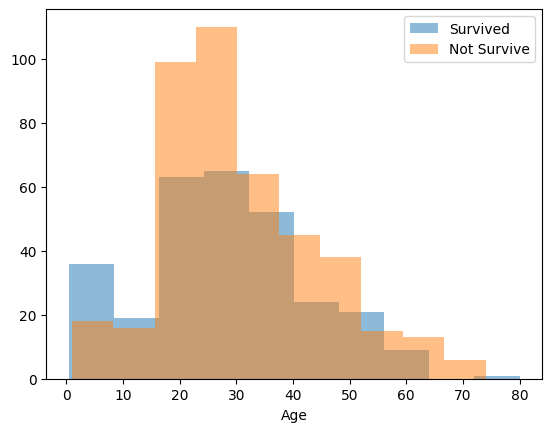

In [7]:
survived = df[df['Survived'] == 1]
not_survive = df[df['Survived'] == 0]

plt.hist(survived['Age'], alpha=.5, label='Survived')
plt.hist(not_survive['Age'], alpha=.5,  label= 'Not Survive')
plt.xlabel('Age')
plt.legend()
plt.show()

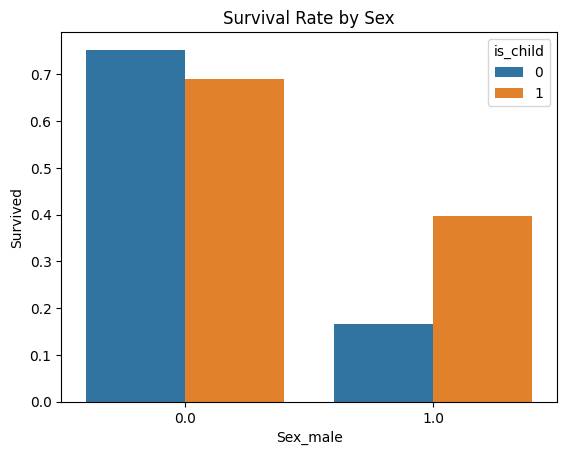

In [8]:
sns.barplot(x='Sex_male', y='Survived', hue='is_child', data=modeling_df, errorbar=None)
plt.title("Survival Rate by Sex")
plt.show()

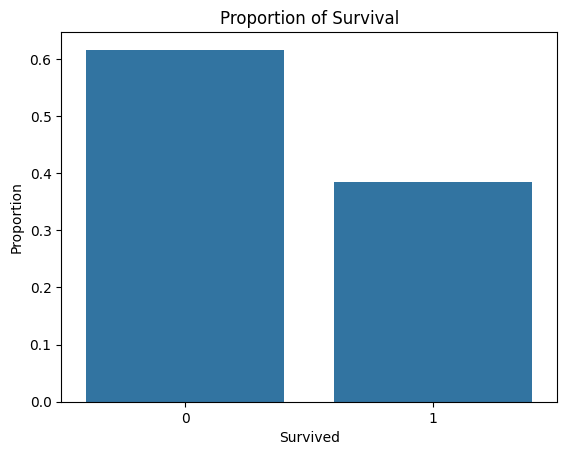

In [9]:
target_dist = pd.DataFrame(modeling_df['Survived'].value_counts(normalize=True))

target_dist.columns = ['Proportion']

sns.barplot(x='Survived', y='Proportion', data=target_dist)
plt.title('Proportion of Survival')
plt.xlabel('Survived')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

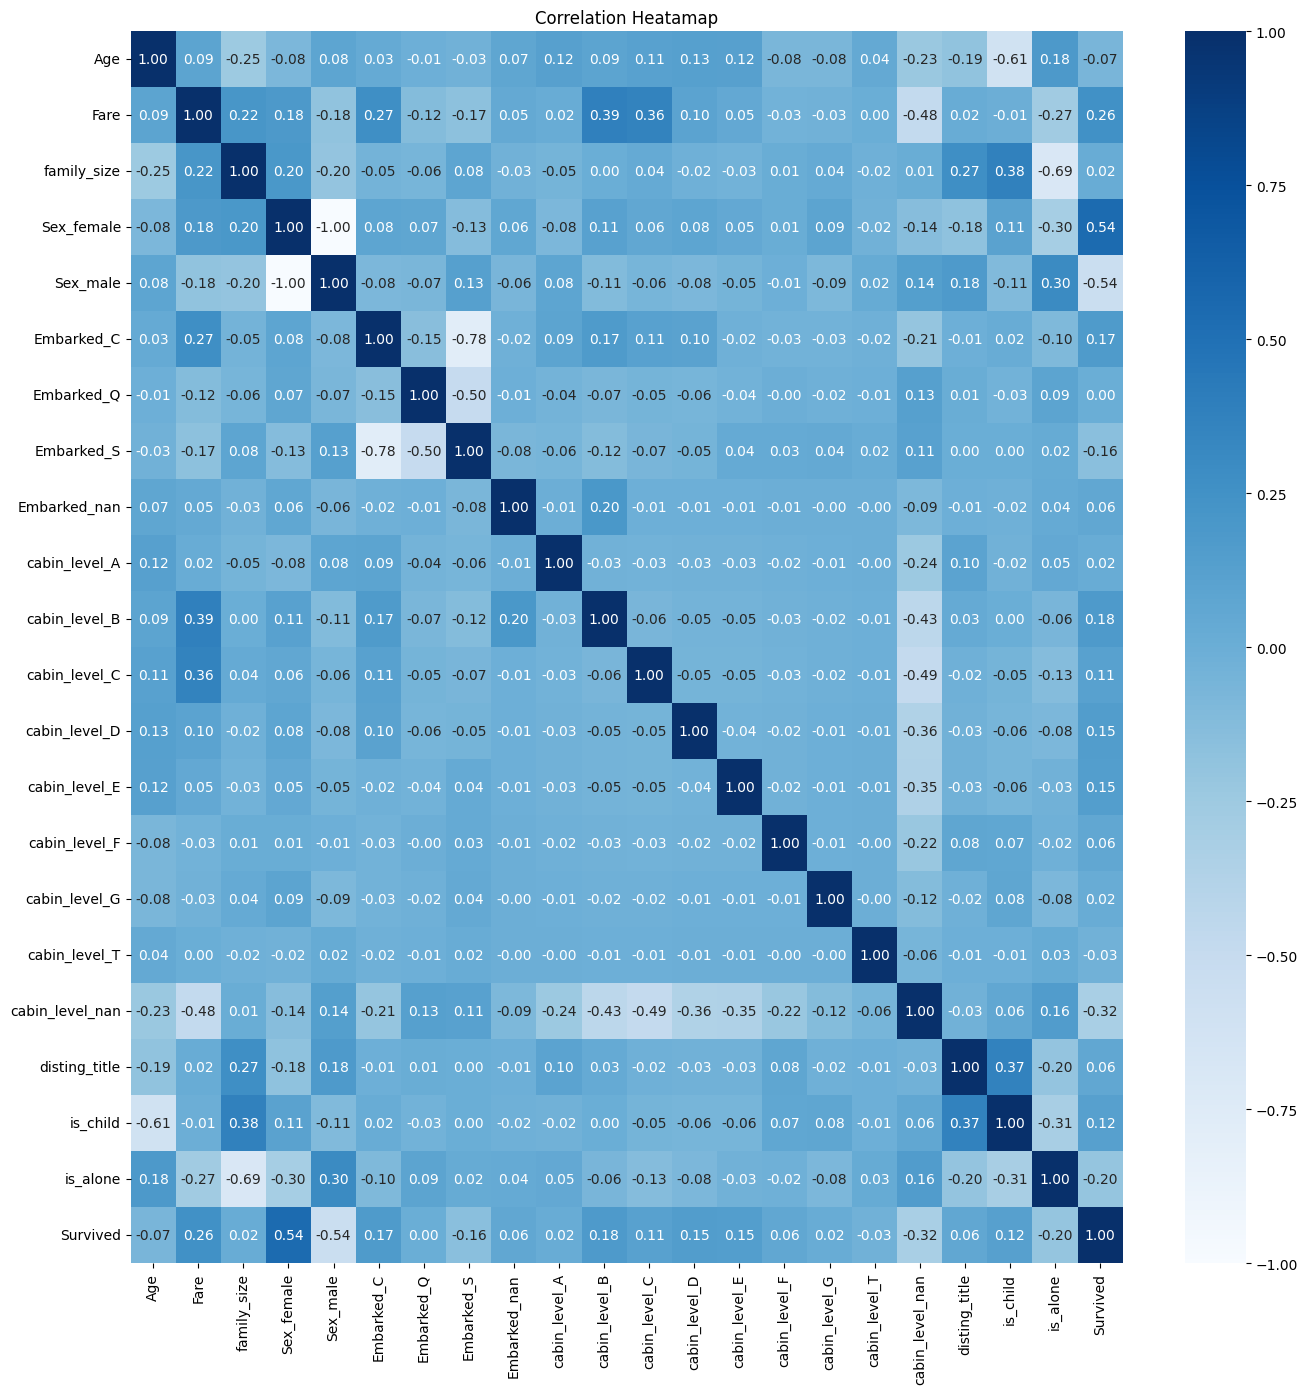

In [10]:
# corr_df = modeling_df.drop(columns=drop_cols).copy()

plt.figure(figsize=(16,16))
corr =  modeling_df.corr()
sns.heatmap(corr, cmap='Blues', annot=True, fmt=".2f")
plt.title("Correlation Heatamap")
plt.show()

# LightGBM Modeling

In [11]:
param_grid_lgbm = {
    "num_leaves": [31, 63],
    "max_depth": [-1, 6],               
    "min_child_samples": [20, 50],
    "learning_rate": [0.02, 0.1],
    "subsample": [0.8],                 
    "subsample_freq": [1],              
    "colsample_bytree": [0.8],          
    "reg_alpha": [0, 0.1],              
    "reg_lambda": [1, 10],              
}


model = LGBMClassifier(
    objective="binary",
    metric="binary_error",
    n_estimators=5000,      
    num_threads=1,          
    random_state=42
)

clf = GridSearchCV(
    estimator=model, 
    param_grid=param_grid_lgbm, 
    cv=3, 
    scoring="accuracy", 
    n_jobs=-1, 
    error_score="raise",
    pre_dispatch=16
    )

best_model = clf.fit(
    x_train_transformed, 
    y_train,
    eval_set= [(x_test_transformed, y_test)],
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=0)
    ])

[LightGBM] [Info] Number of positive: 154, number of negative: 261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 415, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.371084 -> initscore=-0.527568
[LightGBM] [Info] Start training from score -0.527568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

In [12]:
# Feature importance for LightGBM
lgb_model = best_model.best_estimator_

importance_gain = lgb_model.booster_.feature_importance(importance_type='gain')
importance_split = lgb_model.booster_.feature_importance(importance_type='split')

feature_imp_df = pd.DataFrame({
    'feature': lgb_model.booster_.feature_name(),
    'importance_gain': importance_gain,
    'importance_split': importance_split
}).sort_values(by='importance_gain', ascending=False)

feature_imp_df.to_clipboard()
# feature_imp_df

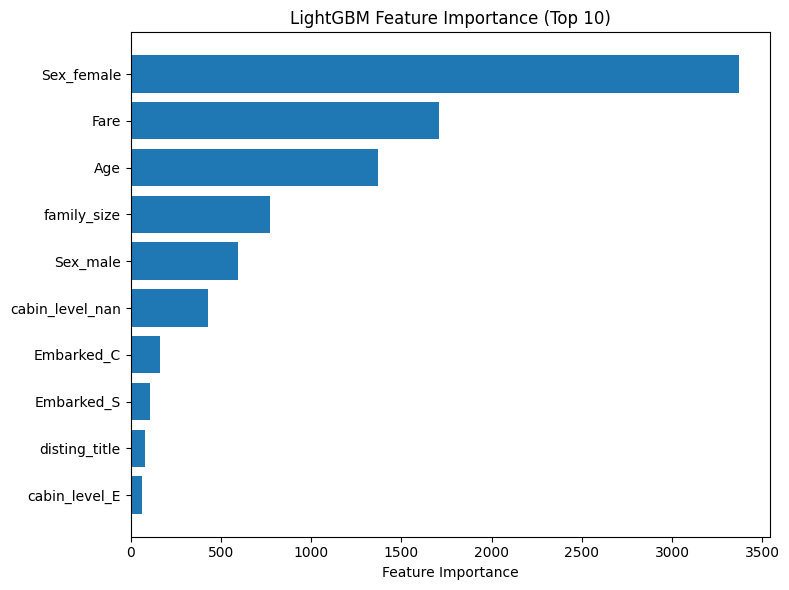

In [13]:
feat_import_lgb = feature_imp_df[['feature', 'importance_gain']]
feat_import_lgb = feat_import_lgb.sort_values(by='importance_gain', ascending=False)
feat_import_lgb = feat_import_lgb.head(10)
feat_import_lgb = feat_import_lgb.sort_values('importance_gain', ascending=True)

plt.figure(figsize=(8,6))
plt.barh(feat_import_lgb['feature'], feat_import_lgb['importance_gain'])
plt.xlabel("Feature Importance")
plt.title("LightGBM Feature Importance (Top 10)")
plt.tight_layout()
plt.show()


In [14]:
y_pred_best = best_model.predict(x_test_transformed)

print("Classification Report WITH Hyperparameter tuning")
print(classification_report(y_test, y_pred_best))

Classification Report WITH Hyperparameter tuning
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       157
           1       0.83      0.73      0.78       111

    accuracy                           0.82       268
   macro avg       0.83      0.81      0.82       268
weighted avg       0.82      0.82      0.82       268



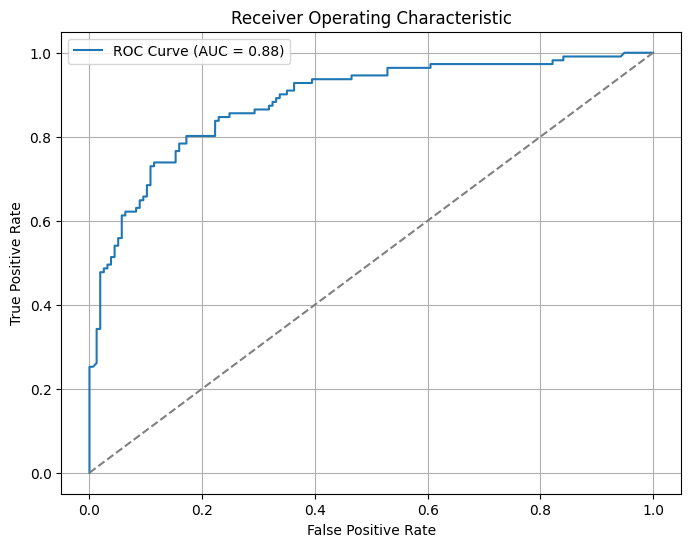

In [15]:
y_prob = best_model.predict_proba(x_test_transformed)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid(True)
plt.show()

## Summary of LightGBM
### Model info
- Gradient boosting framework: builds multiple decision trees that learns from the previous one
- Instead of growing level by level (like XGBoost), grows by choosing the leaf that reduces loss the most
    - leads to deeper, more accurate trees with fewer number of trees
- Can handle categorical features natively

### Feature gain and split:
#### Description:
- Feature gain indicates predictive power within the trees
- Feature split measures how frequently the feature is used as a node within the trees
#### Output Summary
- Sex_female is the most predictive feature (high importance gain)
    - moderate importance split (how often it is  used wihtin the trees)
    - Follows the "Woman and children first" idea
- Fare is the second most predictive feature and has the highest split
- Age also is high in both predictve power and splits
    - Follows the "Woman and children first" idea
- The features show moderate predictive power and splits
    - family_size
    - Sex_male
    - cabin_level_nan
    - Embarked_C
- These features are low in gain and split:
    - disting_title
    - Embarked_S
    - is_child
    - is_alone
    - cabin_level_E
    - cabin_level_C
    - cabin_level_B

## Model Performance 
### Accuracy: 82%
### AUC = 88%